In [2]:
import os, requests, zipfile, io
import pandas as pd
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier

# 1. Script para Download dos dados do ENADE - 2017 a 2019

In [18]:
# Modificando para o diretório atual
os.chdir(os.path.abspath(''))

In [3]:
## Importando os dados de 2017
r = requests.get('https://download.inep.gov.br/microdados/Enade_Microdados/microdados_Enade_2017_portal_2018.10.09.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(os.path.abspath('')+'/dados/enade2017')

In [4]:
## Importando os dados de 2018
r = requests.get('https://download.inep.gov.br/microdados/Enade_Microdados/microdados_enade_2018.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(os.path.abspath('')+'/dados/enade2018')

In [5]:
## Importando os dados de 2019
r = requests.get('https://download.inep.gov.br/microdados/Enade_Microdados/microdados_enade_2019.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(os.path.abspath('')+'/dados/enade2019')

# 2. Base de dados SQLite 

In [3]:
#inicia a engine do banco de dados
engine = sqlalchemy.create_engine('sqlite:///enade.db', echo=False)

In [3]:
# Carrega os dados nos dataframes
df2017 = pd.read_csv("./dados/enade2017/3.DADOS/MICRODADOS_ENADE_2017.txt", encoding='utf-8', sep = ';')
df2018 = pd.read_csv("./dados/enade2018/2018/3.DADOS/microdados_enade_2018.txt", encoding='utf-8', sep = ';' )
df2019= pd.read_csv("./dados/enade2019/3.DADOS/microdados_enade_2019.txt", encoding='utf-8', sep = ';')

C:\Users\melis\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (29,31,32,44,45,46,47,54,55,56) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\melis\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (48,49,50,51,52,53,57,58,59,84,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df = pd.concat([df2017, df2018, df2019])

## 2.1. Adiciona os dados ao banco de dados

In [6]:
df2017.to_sql("enade", con=engine, if_exists="append", index=False)

In [7]:
df2018.to_sql("enade", con=engine, if_exists="append", index=False)

In [8]:
df2019.to_sql("enade", con=engine, if_exists="append", index=False)

## 2.2. Cria as tabelas relacionais no Banco de Dados de acordo com o Modelo de Estrela

In [9]:
#tabela EXAME_ENADE
with engine.connect() as con:
    con.execute(
     """
     create table EXAME_ENADE as 
     select NU_ANO, TP_PRES, NT_GER from enade
     """)

In [10]:
#tabela ALUNO
with engine.connect() as con:
    con.execute(
     """
     create table ALUNO as 
     select NU_IDADE TP_SEXO, ANO_FIM_EM, TP_INSCRICAO_ADM, TP_INSCRICAO from enade
     """)

In [11]:
#tabela INSTITUICAO
with engine.connect() as con:
    con.execute(
     """
     create table INSTITUICAO as 
     select CO_IES, CO_CATEGAD, CO_ORGACAD from enade
     """)

In [12]:
#tabela CURSO
with engine.connect() as con:
    con.execute(
     """
     create table CURSO as 
     select  CO_GRUPO, CO_CURSO, CO_MODALIDADE, CO_MUNIC_CURSO, CO_UF_CURSO, CO_REGIAO_CURSO, ANO_IN_GRAD, CO_TURNO_GRADUACAO from enade
     """)

In [14]:
#tabela PROVA
with engine.connect() as con:
    con.execute(
     """
     create table PROVA as 
     select TP_PR_GER, NT_FG from enade
     """)

In [15]:
#tabela DISCURSIVA
with engine.connect() as con:
    con.execute(
     """
     create table DISCURSIVA as 
     select TP_PR_DI_FG, TP_PR_DI_CE, TP_SFG_D1, TP_SFG_D2, TP_SCE_D1, TP_SCE_D2, TP_SCE_D3, NT_DIS_FG, NT_FG_D1, 
     NT_FG_D1_PT, NT_FG_D1_CT, NT_FG_D2, NT_FG_D2_PT, NT_FG_D2_CT, NT_CE, NT_DIS_CE, NT_CE_D1, NT_CE_D2, NT_CE_D3 from enade
     """)

In [17]:
#tabela OBJETIVA
with engine.connect() as con:
    con.execute(
     """
     create table OBJETIVA as 
     select NU_ITEM_OFG, NU_ITEM_OFG_Z, NU_ITEM_OFG_X, NU_ITEM_OFG_N, NU_ITEM_OCE, NU_ITEM_OCE_Z, NU_ITEM_OCE_X,
     NU_ITEM_OCE_N, TP_PR_OB_FG, TP_PR_OB_CE, NT_OBJ_FG, NT_OBJ_CE from enade
     """)

In [18]:
#tabela GABARITO
with engine.connect() as con:
    con.execute(
     """
     create table GABARITO as 
     select DS_VT_GAB_OFG_ORIG, DS_VT_GAB_OFG_FIN, DS_VT_GAB_OCE_ORIG, DS_VT_GAB_OCE_FIN, DS_VT_ESC_OFG, DS_VT_ACE_OFG,
     DS_VT_ESC_OCE, DS_VT_ACE_OCE from enade
     """)

In [19]:
#tabela QUESTIONARIO_PROVA
with engine.connect() as con:
    con.execute(
     """
     create table QUESTIONARIO_PROVA as 
     select CO_RS_I1, CO_RS_I2, CO_RS_I3, CO_RS_I4, CO_RS_I5, CO_RS_I6, CO_RS_I7, CO_RS_I8, CO_RS_I9 from enade
     """)

In [20]:
#tabela QUESTIONARIO_ALUNO
with engine.connect() as con:
    con.execute(
     """
     create table QUESTIONARIO_ALUNO as 
     select QE_I01, QE_I02, QE_I03, QE_I04, QE_I05, QE_I06, QE_I07, QE_I08, QE_I09, QE_I10, QE_I11
     QE_I12, QE_I13, QE_I14, QE_I15, QE_I16, QE_I17, QE_I18, QE_I19, QE_I20, QE_I21, QE_I22
     QE_I23, QE_I24, QE_I25, QE_I26, QE_I27, QE_I28, QE_I29, QE_I30, QE_I31, QE_I32, QE_I32
     QE_I33, QE_I34, QE_I35, QE_I36, QE_I37, QE_I38, QE_I39, QE_I40, QE_I41, QE_I42, QE_I43
     QE_I44, QE_I45, QE_I46, QE_I47, QE_I48, QE_I49, QE_I50, QE_I51, QE_I52, QE_I53, QE_I54
     QE_I55, QE_I56, QE_I57, QE_I58, QE_I59, QE_I60, QE_I61, QE_I62, QE_I63, QE_I64, QE_I65
     QE_I66, QE_I67, QE_I68 from enade
     """)

In [21]:
#tabela QUESTIONARIO_LICENCIATURA
with engine.connect() as con:
    con.execute(
     """
     create table QUESTIONARIO_LICENCIATURA as 
     select QE_I69, QE_I70, QE_I71, QE_I72, QE_I73, QE_I74, QE_I75, QE_I76, QE_I77
     QE_I78, QE_I79, QE_I80, QE_I81 from enade
     """)

In [23]:
#drop da table não relacional
with engine.connect() as con:
    con.execute(
     """
     drop table enade
     """)

# 3. Análise Exploratória

In [17]:
df.head()

,NU_ANO,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_GRUPO,CO_CURSO,CO_MODALIDADE,CO_MUNIC_CURSO,CO_UF_CURSO,CO_REGIAO_CURSO,...,QE_I72,QE_I73,QE_I74,QE_I75,QE_I76,QE_I77,QE_I78,QE_I79,QE_I80,QE_I81
0,2017,1,1,10028,5710,3,1,5103403,51,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017,1,1,10028,5710,3,1,5103403,51,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,1,1,10028,5710,3,1,5103403,51,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017,1,1,10028,5710,3,1,5103403,51,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017,1,1,10028,5710,3,1,5103403,51,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3.1. Porcentagem dos gêneros nas provas do ENADE

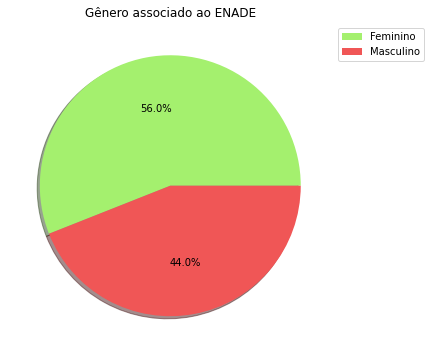

In [6]:
plt.figure(figsize=(10,6))
plt.pie(df.TP_SEXO.value_counts(), autopct='%1.1f%%', shadow=True, colors=['#A4F06E','#F05656'])
plt.title('Gênero associado ao ENADE')
plt.legend(bbox_to_anchor=(1, 1), labels=['Feminino','Masculino'])
plt.show()

## 3.2. Porcentagem de Cor e Raça nas provas do ENADE

In [7]:
#modificando os valores das labels para amostragem
cor_raca = df['QE_I02'].replace({'A': 'Branca', 'B':'Preta', 'C':'Amarela', 'D':'Parda', 'E':'Indígena', 'F':'Não Declarado'})

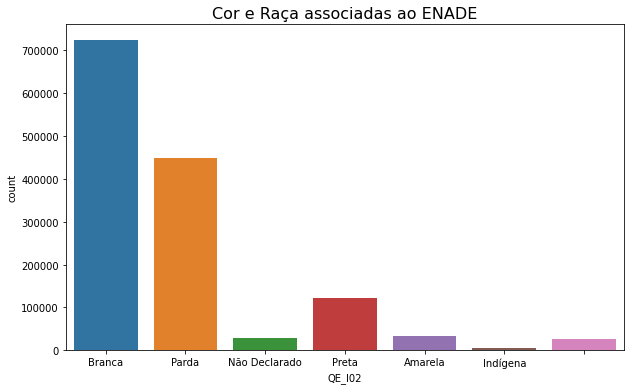

In [8]:
plt.figure(figsize=(10,6))
plt.title("Cor e Raça associadas ao ENADE", fontsize=16)
sns.countplot(x=cor_raca)

plt.show()

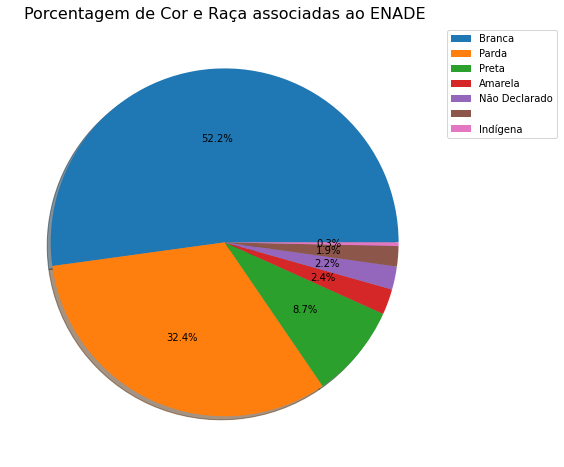

In [10]:
plt.figure(figsize=(10,8))
plt.title("Porcentagem de Cor e Raça associadas ao ENADE", fontsize=16)
plt.pie(cor_raca.value_counts(), autopct='%1.1f%%', shadow=True)
plt.legend(bbox_to_anchor=(1, 1), loc='best', labels=cor_raca.value_counts().index)
plt.show()

## 3.3. Renda dos inscritos no ENADE

In [5]:
#modificando os valores das labels para amostragem
renda = df['QE_I08'].replace({'A': 'Até 1,5 salário mínimo', 'B':'De 1,5 a 3 salários mínimos', 'C':'De 3 a 4,5 salários mínimos', 'D':'De 4,5 a 6 salários mínimos', 'E':'De 6 a 10 salários mínimos', 'F':'De 10 a 30 salários mínimos', 'G':'Acima de 30 salários mínimos'})

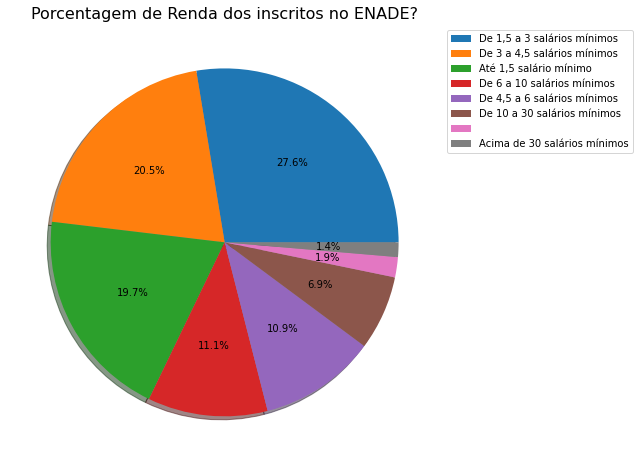

In [7]:
plt.figure(figsize=(10,8))
plt.title("Porcentagem de Renda dos inscritos no ENADE?", fontsize=16)
plt.pie(renda.value_counts(), autopct='%1.1f%%', shadow=True)
plt.legend(bbox_to_anchor=(1, 1), loc='best', labels=renda.value_counts().index)

plt.show()

## 3.4. Estados mais frequentes no ENADE

In [13]:
#modificando os valores das labels para amostragem
estado = df['CO_UF_CURSO'].replace({12: "AC", 27: "AL", 16: "AP", 13: "AM", 29: "BA", 23: "CE", 53: "DF", 32: "ES", 52: "GO", 21: "MA",
 51: "MT", 50: "MS", 31: "MG", 15: "PA", 25: "PB",41: "PR", 26: "PE", 22: "PI", 24: "RN", 
 43: "RS", 33: "RJ", 11: "RR", 14: "RO", 42: "SC", 35: "SP", 28: "SE", 17: "TO"})

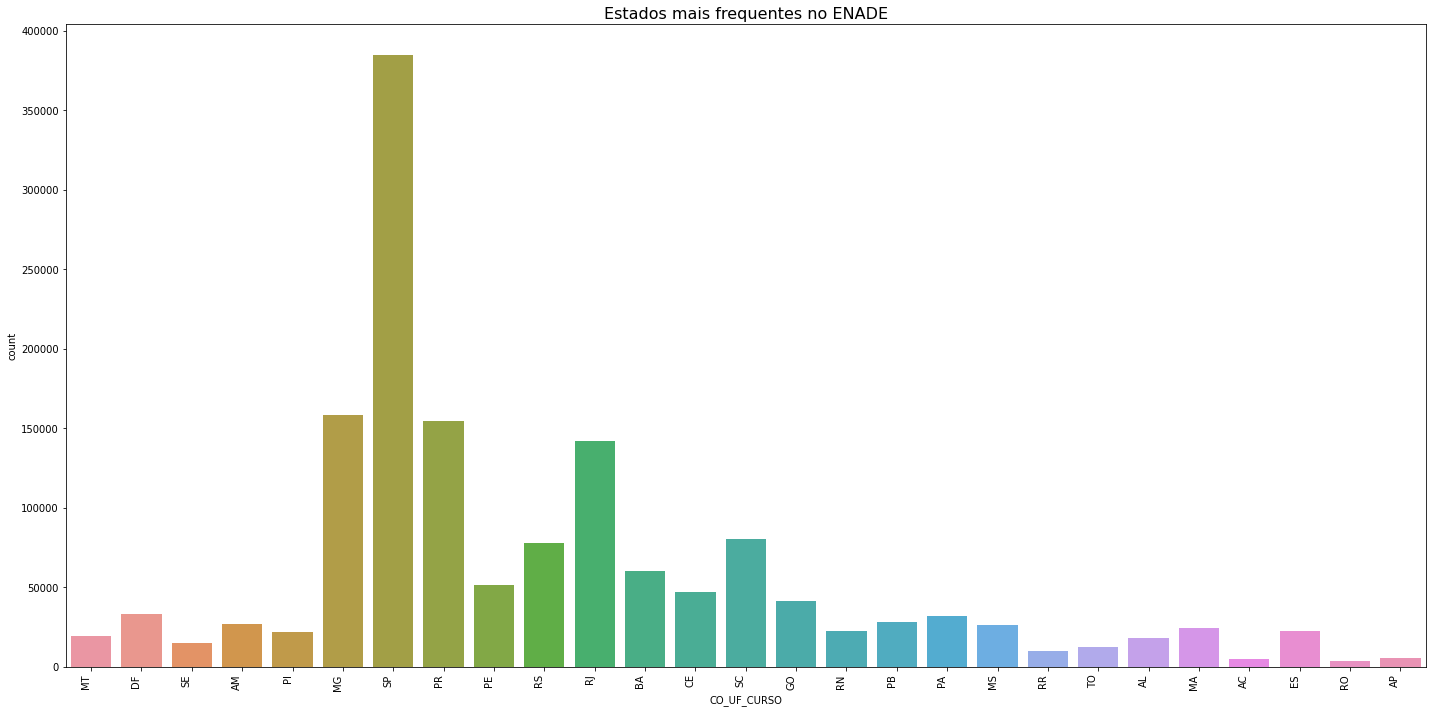

In [14]:
plt.figure(figsize=(20,10))
plt.title("Estados mais frequentes no ENADE", fontsize=16)

ax = sns.countplot(x=estado)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

## 3.5. Quão difícil consideram a prova específica os inscritos no ENADE

In [15]:
#modificando os valores das labels para amostragem
nota = df['CO_RS_I2'].replace({'A': 'Muito fácil.', 'B':'Fácil.', 'C':'Médio.', 'D':'Difícil.', 'E':'Muito difícil.', '*':'Resposta anulada', '.':'Não respondeu'})

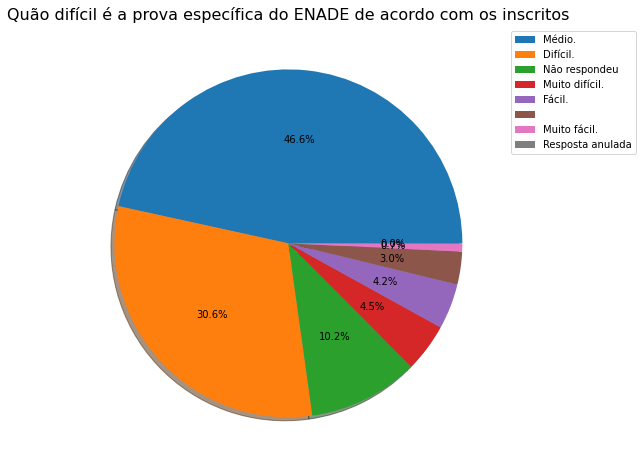

In [16]:
plt.figure(figsize=(10,8))
plt.title("Quão difícil é a prova específica do ENADE de acordo com os inscritos", fontsize=16)
plt.pie(nota.value_counts(), autopct='%1.1f%%', shadow=True)
plt.legend(bbox_to_anchor=(1, 1), loc='best', labels=nota.value_counts().index)

plt.show()

# Feature Engineering

## Label Encoder 

Para esta predição, trabalhar com dados categóricos, como por exemplo "Y" para "sim" e "N" para "não", pode confundir os algoritmos de machine learning, levando à resultados errôneos e/ou lentidão no processamento.

Para contornar este erro, podemos utilizar a técnica de Label Encoder.

In [ ]:
df = df.apply(skl.preprocessing.LabelEncoder().fit_transform)

# 4. Aprendizado de Máquina

## Tentando prever a nota dos inscritos no ENADE 

## Divindo os dados em Treino e Teste

In [35]:
df.dropna(inplace=True)

In [36]:
#valores de entrada
x = df.drop(['NT_GER'], axis=1).values
#valores de saída
y = df['NT_GER'].values

In [42]:
#dividindo os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [38]:
print('Tamanho do conjunto de Treino: {}'.format(len(x_train)))
print('Tamanho do conjunto de Teste: {}'.format(len(x_test)))

Tamanho do conjunto de Treino: 151817
Tamanho do conjunto de Teste: 75909


## Árvore de Decisão

Algoritmo de aprendizado de máquina supervisionado, comumente utilizado para classificação e regressão.

Hiperparâmetros que iremos utilizar:

* criterion
* max_depth
* min_samples_split
* random_state

In [46]:
#Primeiro modelo de árvore de decisão
modelTree1 = DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_split=4, random_state=42)

In [44]:
#treinamento do modelo
modelTree1.fit(x_train, y_train)

#teste do modelo
print("A acurácia do teste foi de:", accuracy_score(y_test, modelTree1.predict(x_test)))

A acurácia do teste foi de: 0.020287182189434858


## Rede Neural MLP

In [49]:
#Modelo de rede neural MLP
mlp = MLPClassifier(hidden_layer_sizes=(10,10,10), activation='relu', solver='adam', max_iter=500)

In [50]:
#treinamento do modelo
mlp.fit(x_train,y_train)

MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=500)

In [51]:
#teste do modelo
predict_test = mlp.predict(x_test)

In [52]:
print("A acurácia do teste foi de:", accuracy_score(y_test, mlp.predict(x_test)))

A acurácia do teste foi de: 0.003842269354059632


In [53]:
#Métricas para avaliação do Modelo
print(classification_report(y_test,predict_test))

              precision    recall  f1-score   support

           0       0.80      0.54      0.65        76
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00        16
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         5
          19       0.00      0.00      0.00         8
          20       0.00      0.00      0.00         4
          21       0.00      0.00      0.00         7
          22       0.00      0.00      0.00        10
          23       0.00      0.00      0.00         4
          24       0.00    

C:\Users\melis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\melis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\melis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo